In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(os.path.dirname(os.path.abspath('.')))

In [2]:
num_samples = 10000
log_data = pd.read_csv(f'../data/logs/{num_samples}/Eat.csv', index_col=False)
print(log_data['mode_final_choice'].unique())
print(log_data['amenity_final_choice'].unique())

['Walking' 'Public_transport' 'Public transport' nan 'Car']
['F&B Eatery/Limited-Service Restaurants'
 'F&B Eatery/Snack and Nonalcoholic Beverage Bars'
 'F&B Eatery/Full-Service Restaurants' nan 'F&B Eatery/Drinking Places'
 'F&B Eatery/Special Food Services']


In [3]:
mode_mapping = {
    'Car': 'Car',
    'Walking': 'Walking',
    'Public_transport': 'Public_transport',
    'Public transport': 'Public_transport',
    'Driving own car': 'Car',
}
amenity_mapping = {
    'F&B Eatery/Limited-Service Restaurants': 'F&B Eatery/Limited-Service Restaurants',
    'F&B Eatery/Snack and Nonalcoholic Beverage Bars': 'F&B Eatery/Snack and Nonalcoholic Beverage Bars',
    'F&B Eatery/Full-Service Restaurants': 'F&B Eatery/Full-Service Restaurants',
    'F&B Eatery/Drinking Places': 'F&B Eatery/Drinking Places',
    'F&B Eatery/Special Food Services': 'F&B Eatery/Special Food Services',
    'F&amp;B Eatery/Snack and Nonalcoholic Beverage Bars': 'F&B Eatery/Snack and Nonalcoholic Beverage Bars',
    'F&amp;B Eatery/Full-Service Restaurants': 'F&B Eatery/Full-Service Restaurants',
    "'F&B Eatery/Full-Service Restaurants'": 'F&B Eatery/Full-Service Restaurants',
    "'F&B Eatery/Snack and Nonalcoholic Beverage Bars'": 'F&B Eatery/Snack and Nonalcoholic Beverage Bars',
    "'F&B Eatery/Drinking Places'": 'F&B Eatery/Drinking Places',
    "'F&B Eatery/Limited-Service Restaurants'": 'F&B Eatery/Limited-Service Restaurants',
}
log_data['predict_mode'] = log_data['mode_final_choice'].map(mode_mapping)
log_data['predict_amenity'] = log_data['amenity_final_choice'].map(
    amenity_mapping)
log_data = log_data.drop(
    columns=['mode_recommendation', 'amenity_recommendation', 'cypher'])
log_data = log_data.dropna()
log_data.head(2)

,person_id,profile,top_k,desire,city,amenity_llm_choice,amenity_final_choice,mode_llm_choice,mode_final_choice,predict_mode,predict_amenity
0,5.570035e+18,"A 29 year old person, living in a family_singl...",50,Eat,Boston,"{ \n""thought"": ""Based on the profile, this per...",F&B Eatery/Limited-Service Restaurants,"{ \n ""thought"": ""Based on the profile of a si...",Walking,Walking,F&B Eatery/Limited-Service Restaurants
1,7.600486e+18,"A 26 year old person, living in a nonfamily_si...",50,Eat,Boston,"{\n ""thought"": ""Based on the profile, this pe...",F&B Eatery/Snack and Nonalcoholic Beverage Bars,"{ \n ""thought"": ""Based on the profile of a ...",Walking,Walking,F&B Eatery/Snack and Nonalcoholic Beverage Bars


In [4]:
test_data = pd.read_csv('../data/test/Eat.csv', index_col=False)

income_bins = [-float('inf'), 0, 30000, 60000, 90000, 120000, float('inf')]
income_labels = ['Debt', 'Low', 'Moderate', 'High', 'Very High', 'Ultra High']
age_bins = [-float('inf'), 18, 30, 40, 50, 60, float('inf')]
age_labels = ['Teen', 'Young Adult', 'Adult',
              'Middle Age', 'Senior', 'Elderly']

test_data['income_group'] = pd.cut(
    test_data['individual_income'], bins=income_bins, labels=income_labels)
test_data['age_group'] = pd.cut(
    test_data['age'], bins=age_bins, labels=age_labels)
test_data['income_group'] = pd.cut(
    test_data['individual_income'], bins=income_bins, labels=income_labels)
test_data['age_group'] = pd.cut(
    test_data['age'], bins=age_bins, labels=age_labels)
test_data['target_mode'] = test_data['mode']
test_data.head(2)

,person_id,travel_purpose,target_amenity,mode,distance_miles,duration_minutes,age,individual_income,household_size,family_structure,vehicles,cypher,income_group,age_group,target_mode
0,5.570035e+18,Eat,F&B Eatery/Drinking Places,Walking,0.0,0.0,29,53672,3_person,family_single,1,\n MATCH (p:Person)\n WHERE (p.a...,Moderate,Young Adult,Walking
1,7.600486e+18,Eat,F&B Eatery/Snack and Nonalcoholic Beverage Bars,Walking,0.0,0.0,26,0,3_person,nonfamily_single,0,\n MATCH (p:Person)\n WHERE (p.a...,Debt,Young Adult,Walking


In [5]:
pred_data = log_data[['person_id', 'predict_mode', 'predict_amenity']]
true_data = test_data[['person_id', 'income_group',
                       'age_group', 'target_amenity', 'target_mode']]

merged_data = pd.merge(pred_data, true_data, on='person_id')
merged_data = merged_data.dropna()
merged_data.head()

,person_id,predict_mode,predict_amenity,income_group,age_group,target_amenity,target_mode
0,5.570035e+18,Walking,F&B Eatery/Limited-Service Restaurants,Moderate,Young Adult,F&B Eatery/Drinking Places,Walking
1,7.600486e+18,Walking,F&B Eatery/Snack and Nonalcoholic Beverage Bars,Debt,Young Adult,F&B Eatery/Snack and Nonalcoholic Beverage Bars,Walking
2,8.362513e+18,Walking,F&B Eatery/Full-Service Restaurants,Low,Elderly,F&B Eatery/Full-Service Restaurants,Car
3,1.381425e+19,Walking,F&B Eatery/Full-Service Restaurants,Moderate,Young Adult,F&B Eatery/Limited-Service Restaurants,Public_transport
4,1.590730e+19,Walking,F&B Eatery/Full-Service Restaurants,Moderate,Young Adult,F&B Eatery/Drinking Places,Walking


In [6]:
def analysis(x, y, pred_y, figsize=(20, 5), order=None):
    contingency_table = pd.crosstab(merged_data[y], merged_data[x])
    percentage_table = contingency_table.div(
        contingency_table.sum(axis=0), axis=1) * 100

    predict_contingency_table = pd.crosstab(
        merged_data[pred_y], merged_data[x])
    predict_percentage_table = predict_contingency_table.div(
        contingency_table.sum(axis=0), axis=1) * 100

    error_table = (predict_percentage_table-percentage_table)/100

    if order:
        percentage_table = percentage_table.reindex(order, axis=1)
        predict_percentage_table = predict_percentage_table.reindex(
            order, axis=1)
        error_table = error_table.reindex(order, axis=1)

    average_error = error_table.abs().mean()
    print("Average Error:", average_error, '\n')
    print("Total Average Error:", average_error.mean(), '\n')

    # draw heatmap
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)

    ax1 = sns.heatmap(percentage_table, annot=True, fmt=".1f",
                      cmap="YlGnBu", vmin=0, vmax=100, ax=axs[0])
    ax2 = sns.heatmap(predict_percentage_table, annot=True,
                      fmt=".1f", cmap="YlGnBu", vmin=0, vmax=100, ax=axs[1])
    ax3 = sns.heatmap(error_table, annot=True, fmt=".2f",
                      cmap="vlag", vmin=-0.5, vmax=0.5, ax=axs[2])

    ax1.set_title("Ground Truth")
    ax2.set_title("Prediction")
    ax3.set_title("Percentage Error")
    for ax in axs:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

Average Error: age_group
Teen           0.000000
Young Adult    0.038033
Adult          0.019512
Middle Age     0.050000
Senior         0.071287
Elderly        0.027826
dtype: float64 

Total Average Error: 0.034443032946098365 



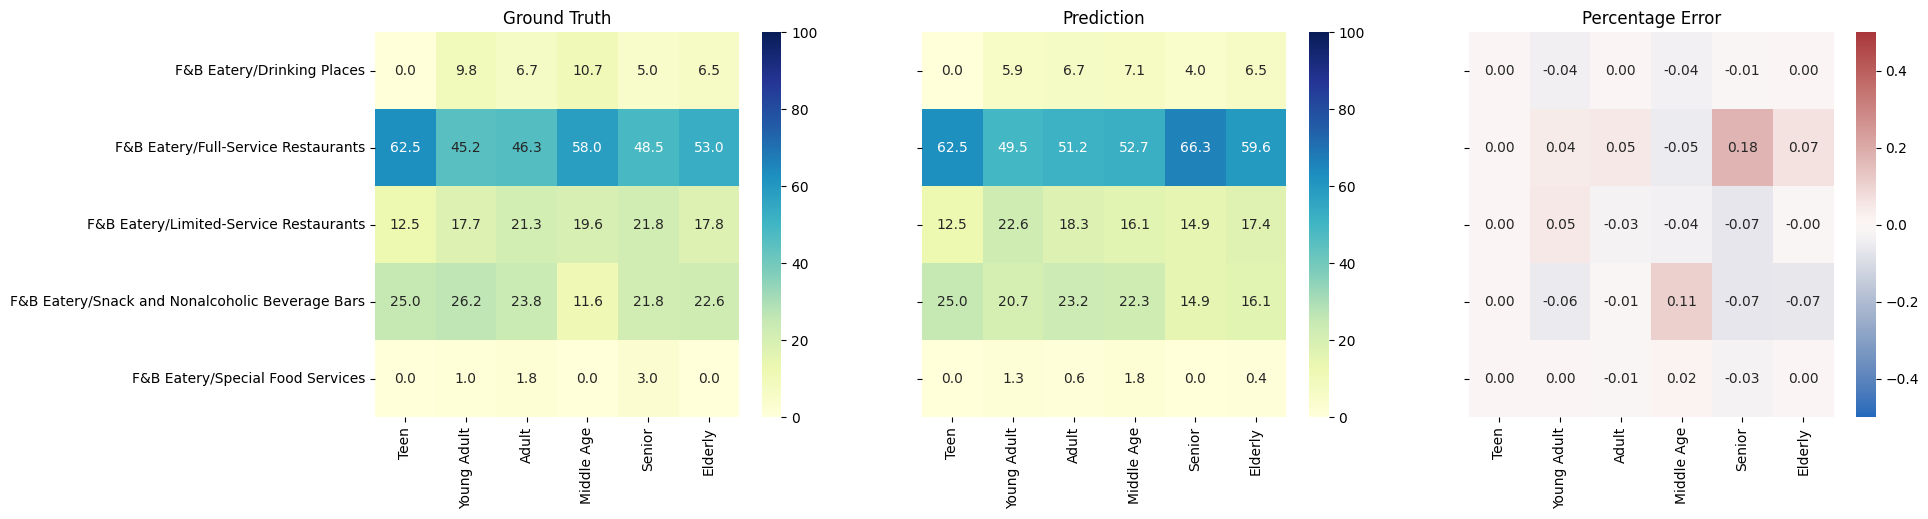

In [7]:
age_mapping = {'Teen': 0, 'Young Adult': 1, 'Adult': 2,
               'Middle Age': 3, 'Senior': 4, 'Elderly': 5}
age_order = list(age_mapping.keys())

analysis(x='age_group', y='target_amenity',
         pred_y='predict_amenity', order=age_order)

Average Error: age_group
Teen           0.166667
Young Adult    0.015301
Adult          0.048780
Middle Age     0.023810
Senior         0.072607
Elderly        0.110145
dtype: float64 

Total Average Error: 0.0728849021652434 



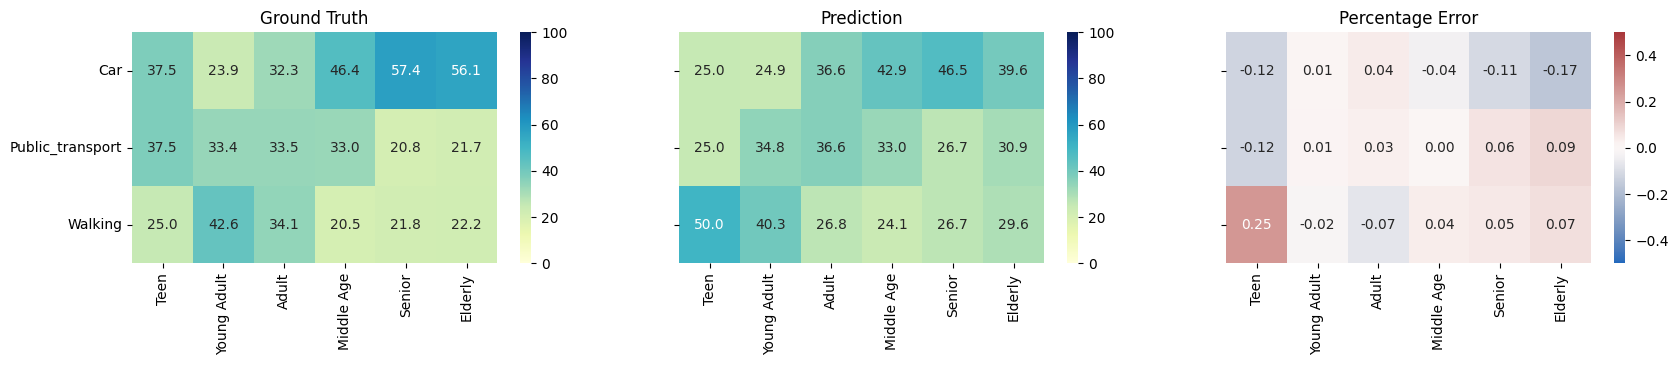

In [8]:
age_mapping = {'Teen': 0, 'Young Adult': 1, 'Adult': 2,
               'Middle Age': 3, 'Senior': 4, 'Elderly': 5}
age_order = list(age_mapping.keys())
analysis(x='age_group', y='target_mode',
         pred_y='predict_mode', figsize=(20, 3))

Average Error: income_group
Debt          0.012121
Low           0.010072
Moderate      0.042424
High          0.031250
Very High     0.110769
Ultra High    0.033613
dtype: float64 

Total Average Error: 0.040041678856479954 



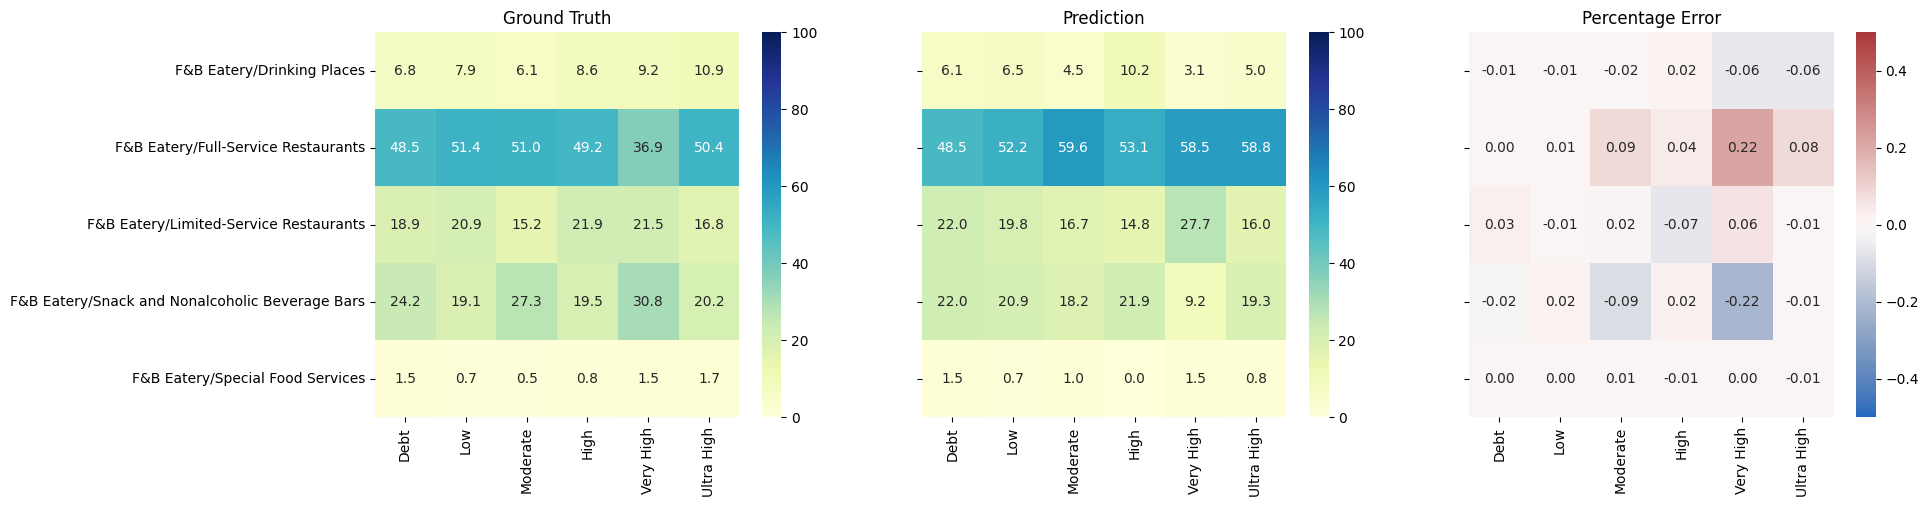

In [9]:
analysis(x='income_group', y='target_amenity', pred_y='predict_amenity')

Average Error: income_group
Debt          0.055556
Low           0.062350
Moderate      0.026936
High          0.005208
Very High     0.000000
Ultra High    0.078431
dtype: float64 

Total Average Error: 0.03808023471300202 



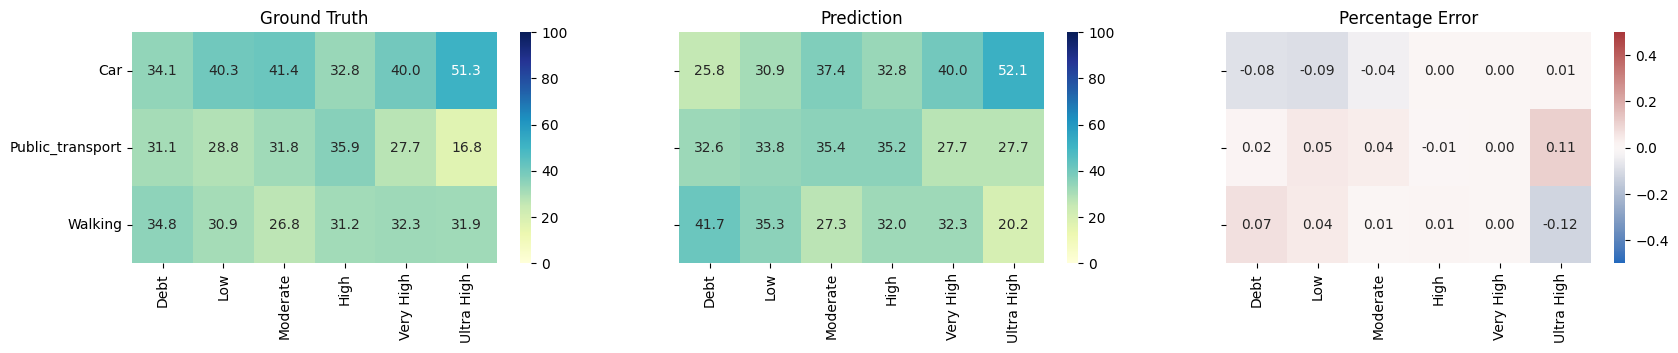

In [10]:
analysis(x='income_group', y='target_mode',
         pred_y='predict_mode', figsize=(20, 3))